# Camera based vehicle detection and tracking

In [1]:
# imports
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

TEST_IMAGES = 'test_images'
OUTPUT_IMAGES = 'output_images'
VEHICLE_EXAMPLE = r'C:\Users\Nassim\Documents\UDACITY\VehicleDetection\training_data\vehicles\KITTI_extracted\42.png'
NONVEHICLE_EXAMPLE = r'C:\Users\Nassim\Documents\UDACITY\VehicleDetection\training_data\non-vehicles\GTI\image42.png'

## Classifier

In [2]:
## Data set parsing
car_dataset = glob.glob('training_data/vehicles/**/*.png')
noncar_dataset = glob.glob('training_data/non-vehicles/**/*.png')
print("There are %d images of cars" % len(car_dataset))
print("There are %d images of non-cars" % len(noncar_dataset) )

There are 8792 images of cars
There are 8968 images of non-cars


### HOG features

In [3]:
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


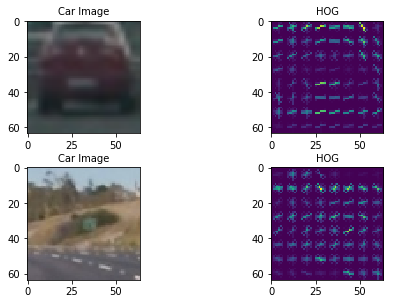

In [4]:
# Read image, convert to grayscale and get HOG
car_image = mpimg.imread(car_dataset[42])
gray_car = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
noncar_image = mpimg.imread(noncar_dataset[42])
gray_noncar = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2GRAY)

features_car, im_car = get_hog_features(gray_car, feature_vec=False, vis=True)
features_noncar, im_noncar = get_hog_features(gray_noncar, feature_vec=False, vis=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
f.tight_layout()

ax1.imshow(car_image)
ax1.set_title('Car Image', fontsize=10)
ax2.imshow(im_car)
ax2.set_title('HOG', fontsize=10)

ax3.imshow(noncar_image)
ax3.set_title('Car Image', fontsize=10)
ax4.imshow(im_noncar)
ax4.set_title('HOG', fontsize=10)


plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig('report_images/HOG1.jpg', dpi=500, bbox_inches='tight')

#### Now let's train a classifier for the HOG features

The code below is based from the lesson's code

##### Set up samples

In [5]:
sample_size = 3000
cars = car_dataset#[0:sample_size]
notcars = noncar_dataset#[0:sample_size]

##### Set parameters

In [6]:
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0

##### Extract the HOG features for each data set

In [7]:
t=time.time()

car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

t2 = time.time()
hog_extract_time = round(t2-t, 2)
print(hog_extract_time, 'Seconds to extract HOG features...')

41.85 Seconds to extract HOG features...


##### Prepare the data for the classifier
create features and labels array, split up data randomly and normalize the data

In [8]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

##### Apply a linear SVM classifier

In [9]:
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
training_time = round(t2-t, 2)
score = round(svc.score(X_test, y_test), 4)

In [10]:
print("| Colorspace | Orient | P/C | C/B | Channel | Extraction time | Training time | Accuracy |")
print("|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|")
print("| %s | %d | %d | %d | %s | %.2fs | %.2fs | %.2f |" % (colorspace, orient, pix_per_cell, cell_per_block, str(hog_channel), hog_extract_time, training_time, score))


| Colorspace | Orient | P/C | C/B | Channel | Extraction time | Training time | Accuracy |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| HSV | 9 | 8 | 2 | 0 | 41.85s | 28.21s | 0.89 |


###### Loop over possible colorspaces and channels parameter combinations

In [11]:
if 0:
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    for cs in ["LUV", "HLS", "YUV", "YCrCb"]: #["RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb"]:
        for ch in [0, 1, 2, "ALL"]:
            try:
                colorspace = cs
                hog_channel = ch
                t=time.time()

                car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                        hog_channel=hog_channel)
                notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                        hog_channel=hog_channel)

                t2 = time.time()
                hog_extract_time = round(t2-t, 2)
                # Create an array stack of feature vectors
                X = np.vstack((car_features, notcar_features)).astype(np.float64)
                # Define the labels vector
                y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
                # Split up data into randomized training and test sets
                rand_state = np.random.randint(0, 100)
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=rand_state)
                # Fit a per-column scaler
                X_scaler = StandardScaler().fit(X_train)
                # Apply the scaler to X
                X_train = X_scaler.transform(X_train)
                X_test = X_scaler.transform(X_test)
                svc = LinearSVC()
                # Check the training time for the SVC
                t=time.time()
                svc.fit(X_train, y_train)
                t2 = time.time()
                training_time = round(t2-t, 2)
                score = round(svc.score(X_test, y_test), 4)
                print("| %s | %d | %d | %d | %s | %.2fs | %.2fs | %.2f |" % (cs, orient, pix_per_cell, cell_per_block, str(ch), hog_extract_time, training_time, score))
            except :
                print("Failed because of:")
                import sys
                print(sys.exc_info()[0])

In [12]:
if 0:
    colorspace = "YCrCb"
    hog_channel = "ALL"
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    for o in [8, 9, 10]: 
        for pc in [8, 10, 12]:
            for cb in [2, 4, 6, 10]:
                try:
                    orient = o
                    pix_per_cell = pc
                    cell_per_block = cb

                    t=time.time()

                    car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                            hog_channel=hog_channel)
                    notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                            hog_channel=hog_channel)

                    t2 = time.time()
                    hog_extract_time = round(t2-t, 2)
                    # Create an array stack of feature vectors
                    X = np.vstack((car_features, notcar_features)).astype(np.float64)
                    # Define the labels vector
                    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
                    # Split up data into randomized training and test sets
                    rand_state = np.random.randint(0, 100)
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=0.2, random_state=rand_state)
                    # Fit a per-column scaler
                    X_scaler = StandardScaler().fit(X_train)
                    # Apply the scaler to X
                    X_train = X_scaler.transform(X_train)
                    X_test = X_scaler.transform(X_test)
                    svc = LinearSVC()
                    # Check the training time for the SVC
                    t=time.time()
                    svc.fit(X_train, y_train)
                    t2 = time.time()
                    training_time = round(t2-t, 2)
                    score = round(svc.score(X_test, y_test), 4)
                    print("| %s | %d | %d | %d | %s | %.2fs | %.2fs | %.5f |" % (colorspace, o, pc, cb, str(hog_channel), hog_extract_time, training_time, score))
                except :
                    print("Failed because of:")
                    import sys
                    print(sys.exc_info()[0])

#### Final classifier
Based on the benchmark above, the following combination is selected:
- orientation = 9
- pixels per cell = 8
- cells per blocks = 4
- colorspace = YCrCb

In [13]:
if 0:
    colorspace = "YCrCb"
    hog_channel = "ALL"
    orient = 9
    pix_per_cell = 12
    cell_per_block = 4 #97,33

    sample_size = 3000
    cars = car_dataset#[0:sample_size]
    notcars = noncar_dataset#[0:sample_size]

    car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    svc = LinearSVC()
    # Check the training time for the SVC
    svc.fit(X_train, y_train)
    score = round(svc.score(X_test, y_test), 4)
    print("Feature shape", X_train[0].shape)
    print(score)

In [14]:
#print(X_test[0].reshape(1,-1).shape)
#print(svc.predict(X_test[0].reshape(1,-1)))

In [15]:
# Pickle classifier
import pickle
import os
pickle_dat = os.path.join(os.getcwd(), r"svc_full.p")
if os.path.isfile(pickle_dat):
    print("data available")
else:
    print("no file, saving classifier")
    data = {}
    data["Classifier"] = svc
    data["Scaler"] = X_scaler
    data["Orientation"] = orient
    data["Pixels_per_cell"] = pix_per_cell
    data["Cells_per_block"] = cell_per_block
    pickle.dump( data, open( pickle_dat, "wb" ) )

# Test loading classifier
data = pickle.load(open( pickle_dat, "rb" ))
svc = data["Classifier"]
print("predicted", svc.predict(X_test[0:5]))
print("labeled", y_test[0:5])

data available


ValueError: X has 1764 features per sample; expecting 1728

Now that the detection part is dealt with, we need to implement the sliding window search on real images.

### Sliding window search

In [16]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [17]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    hits = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            test_prediction = svc.predict(hog_features.reshape(1,-1))
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                hits.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return hits

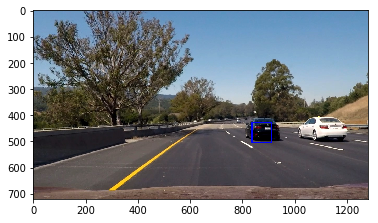

In [18]:
# Load params from pickle file
svc = data["Classifier"]
X_scaler = data["Scaler"]
orient = data["Orientation"]
pix_per_cell = data["Pixels_per_cell"]
cell_per_block = data["Cells_per_block"]
# Define Region of interest: only the lower part of the image is expected to have vehicles
#ystart = 400
#ystop = 656
#scale = 1.5
test_images = glob.glob(TEST_IMAGES + '/*.jpg')
for image_name in test_images:
    image = mpimg.imread(image_name)
    draw_img = np.copy(image)
    # Rescale because training was done on png images
    image = image.astype(np.float32)/255
    #hits = find_cars(image, 400, 656, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    #for hit in hits:
    #    cv2.rectangle(draw_img, hit[0], hit[1],(0,0,255),6) 
    hits_far = find_cars(draw_img, 400, 550, 1.2, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    hits_near = find_cars(draw_img, 550, 656, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    for hit in (hits_far + hits_near):
        cv2.rectangle(draw_img, hit[0], hit[1], (0,0,255), 6) 
    plt.imshow(draw_img)
    plt.savefig(os.path.join(OUTPUT_IMAGES, image_name.split('\\')[-1]), dpi=500, bbox_inches='tight')
    

#### Heat map

In [19]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

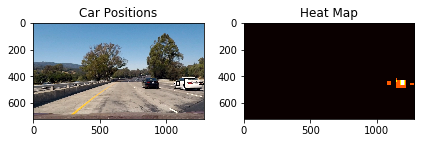

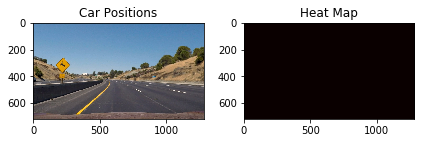

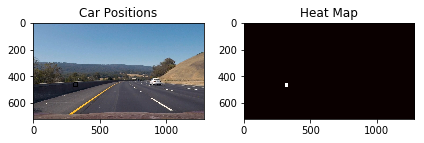

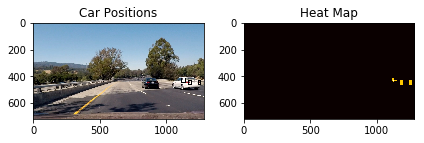

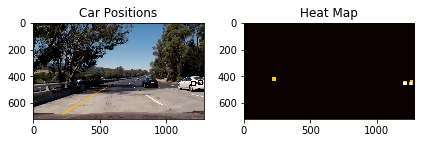

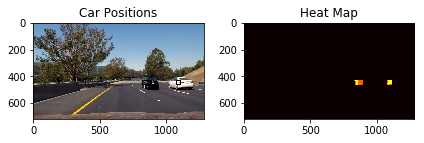

In [20]:
from scipy.ndimage.measurements import label
test_images = glob.glob(TEST_IMAGES + '/*.jpg')
for image_name in test_images:
    image = mpimg.imread(image_name)

    draw_img = np.copy(image)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    image = image.astype(np.float32)/255

    hits_far = find_cars(draw_img, 400, 550, 1.2, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    hits_mid = find_cars(draw_img, 400, 480, 0.5, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    hits_near = find_cars(draw_img, 550, 656, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    box_list = hits_near + hits_mid + hits_far

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.savefig(os.path.join(OUTPUT_IMAGES, image_name.split('\\')[-1].replace('.jpg', '_heatmap.jpg')), dpi=500, bbox_inches='tight')


In [21]:
class Car(object):

    def __init__(self, bbox):
        self.boundingbox = bbox
        self.age = 1
        self.drops = 0
        
    def getAge(self):
        return self.age
    
    def getDrops(self):
        return self.drops
    
    def getPosition(self):
        return self.boundingbox
    

#### Consolidated pipeline

In [22]:
# Don't forget to load the classifier data!
import pickle
from scipy.ndimage.measurements import label

pickle_dat = os.path.join(os.getcwd(), r"svc.p")
    
data = pickle.load(open( pickle_dat, "rb" ))

svc = data["Classifier"]
X_scaler = data["Scaler"]
orient = data["Orientation"]
pix_per_cell = data["Pixels_per_cell"]
cell_per_block = data["Cells_per_block"]

def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    hits = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            test_prediction = svc.predict(hog_features.reshape(1,-1))
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                hits.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return hits

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_labeled_bboxes(labels):
    # Iterate through all detected cars
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
        # Draw the box on the image
    # Return the image
    return bboxes


def processImage(img):
    """ image pipeline
    """
    Cars = []
    draw_img = np.copy(img)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    img = img.astype(np.float32)/255

    hits_2_far  = find_cars(draw_img, 410, 466, 0.7, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    hits_2_near = find_cars(draw_img, 400, 515, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    
    hits_1_far  = find_cars(draw_img, 410, 500, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    hits_1_near = find_cars(draw_img, 400, 564, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    
    hits_mid = find_cars(draw_img, 400, 550, 1.2, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    hits_mid2 = find_cars(draw_img, 420, 480, 0.8, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    
    box_list = hits_2_far + hits_2_near + hits_1_far + hits_1_near + hits_mid + hits_mid2
    
    #hits_far = find_cars(draw_img, 440, 504, 0.9, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    #hits_far2 = find_cars(draw_img, 400, 464, 0.8, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    #hits_mid = find_cars(draw_img, 420, 484, 1.1, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    #hits_mid2 = find_cars(draw_img, 440, 520, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    #hits_mid3 = find_cars(draw_img, 460, 540, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    #hits_near = find_cars(draw_img, 500, 656, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    #box_list = hits_far + hits_mid + hits_near+ hits_mid2 +hits_mid3 + hits_far2
    
    #hits_far = find_cars(draw_img, 400, 550, 1.2, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    #hits_near = find_cars(draw_img, 550, 656, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    #box_list = hits_far + hits_near
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1.0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    bboxes = get_labeled_bboxes(labels)
    for hit in box_list:#bboxes:
        Cars.append(Car(hit))
        cv2.rectangle(draw_img, hit[0], hit[1], (0,0,255), 6)
    
    print(len((Cars)))
    return draw_img, Cars

9


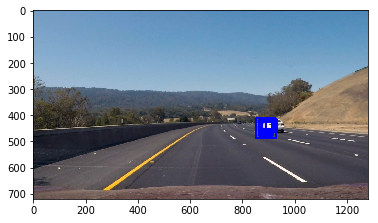

In [23]:
image = mpimg.imread(TEST_IMAGES + r"\test3.jpg")
res, cars = processImage(image)
plt.imshow(res)

In [24]:
print(len(cars))

9


In [25]:
print(cars[0].getPosition())

((868, 410), (912, 454))


### Videopipeline

In [26]:
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import scipy
from functools import reduce

In [27]:
# Lets try at first the pipeline, without any tracking of the cars. The goal is to get an idea of how robust the pipeline is at the moment
MEM_CYCLES = 5
def accumulated_heatmap():
    heatmap_tracking = []
    
    def processVideoImage(img):
        """ image pipeline
        """
        global heatmap_tracking
        draw_img = np.copy(img)
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        img = img.astype(np.float32)/255

        #hits_far = find_cars(draw_img, 400, 480, 0.9, svc, X_scaler, orient, pix_per_cell, cell_per_block)
        #hits_mid = find_cars(draw_img, 400, 550, 1.2, svc, X_scaler, orient, pix_per_cell, cell_per_block)
        #hits_near = find_cars(draw_img, 550, 656, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block)
        #box_list = hits_far + hits_mid + hits_near

        #hits_far = find_cars(draw_img, 400, 550, 1.2, svc, X_scaler, orient, pix_per_cell, cell_per_block)
        #hits_near = find_cars(draw_img, 550, 656, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block)
        #box_list = hits_far + hits_near

        #hits_far = find_cars(draw_img, 440, 504, 0.9, svc, X_scaler, orient, pix_per_cell, cell_per_block)
        #hits_far2 = find_cars(draw_img, 400, 464, 0.8, svc, X_scaler, orient, pix_per_cell, cell_per_block)
        #hits_mid = find_cars(draw_img, 420, 484, 1.1, svc, X_scaler, orient, pix_per_cell, cell_per_block)
        #hits_mid2 = find_cars(draw_img, 440, 520, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block)
        #hits_mid3 = find_cars(draw_img, 460, 540, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block)
        #hits_near = find_cars(draw_img, 500, 656, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block)
        #box_list = hits_far + hits_mid + hits_near+ hits_mid2 +hits_mid3 + hits_far2

        hits_2_far  = find_cars(draw_img, 410, 466, 0.7, svc, X_scaler, orient, pix_per_cell, cell_per_block)
        hits_2_near = find_cars(draw_img, 400, 515, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block)

        #hits_mid = find_cars(draw_img, 400, 550, 1.2, svc, X_scaler, orient, pix_per_cell, cell_per_block)
        #hits_mid2 = find_cars(draw_img, 420, 480, 0.8, svc, X_scaler, orient, pix_per_cell, cell_per_block)

        hits_1_far  = find_cars(draw_img, 410, 500, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block)
        hits_1_near = find_cars(draw_img, 400, 564, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block)

        box_list = hits_2_far + hits_2_near + hits_1_far + hits_1_near


        # Add heat to each box in box list
        heat = add_heat(heat,box_list)

        # heatmap history
        if len(heatmap_tracking) >= MEM_CYCLES:
            heatmap_tracking = heatmap_tracking[1:]

        heatmap_tracking.append(heat)
        heat_history = reduce(lambda h, acc: h + acc, heatmap_tracking)/MEM_CYCLES
        
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat_history, 0.5)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        bboxes = get_labeled_bboxes(labels)
        for hit in bboxes:
            cv2.rectangle(draw_img, hit[0], hit[1], (0,0,255), 6)

        return draw_img

    white_output = 'output_videos/project_video_version2_tracking.mp4'
    #white_output = 'output_videos/test_video_1604.mp4'
    clip1 = VideoFileClip("project_video.mp4")
    #clip1 = VideoFileClip("test_video.mp4")
    white_clip = clip1.fl_image(processVideoImage)
    %time white_clip.write_videofile(white_output, audio=False)

accumulated_heatmap()

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_videos/project_video_version2_tracking.mp4'))